In [1]:
#!pip install torch torchvision
#!pip install opencv-contrib-python
#!pip install scikit-learn

# LeNet

In [2]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import Softmax
from torch.nn import Dropout
from torch import flatten
import torchvision

import matplotlib
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [3]:
class LeNet(Module):
  def __init__(self, numChannels, classes):
    # call the parent constructor
    super(LeNet, self).__init__()
    
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    
    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    
    self.fc1 = Linear(in_features=800, out_features=500)
    self.relu3 = ReLU()
    
    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)
    # pass the output to our softmax classifier to get our output predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)
    # return the output predictions
    return output

In [4]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 5
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load the dataset
print("[INFO] loading dataset...")

import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(227)])

trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())



print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading dataset...
[INFO] generating the train/validation split...


In [6]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


In [7]:
# initialize the model
print("[INFO] initializing the model...")
model_lenet = LeNet(numChannels=1, classes=len(trainData.dataset.classes)).to(device)

model_lenet.eval()

[INFO] initializing the model...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [8]:
opt = Adam(model_lenet.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
print(type(trainDataLoader),len(trainDataLoader))

<class 'torch.utils.data.dataloader.DataLoader'> 352


In [9]:
# Let's start the training
print("[INFO] training the network...")
startTime = time.time()

# loop over epochs
for e in range(0, EPOCHS):
  model_lenet.train()                                            # set the model in training mode

  totalTrainLoss = 0 
  totalValLoss = 0
  trainCorrect = 0
  valCorrect = 0
  # loop over the training set
  for (x, y) in trainDataLoader:
    (x, y) = (x.to(device), y.to(device))
  #for i, data in trainDataLoader:                      
    #x, y = data[0].to(device), data[1].to(device) 
    pred = model_lenet(x)                                         # perform forward pass
    loss = lossFn(pred, y)                                  # calculate the training loss
    
    opt.zero_grad()                                         # zero out the gradients, perform the backpropagation step
    loss.backward()                                         # and update the weights
    opt.step()
    
    totalTrainLoss += loss
    trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

  with torch.no_grad():                             # switch off autograd for evaluation
    model_lenet.eval()                                    # set the model in evaluation mode
    for (x, y) in valDataLoader:
      (x, y) = (x.to(device), y.to(device))
      pred = model_lenet(x)                               # # make the predictions
      totalValLoss += lossFn(pred, y)
      valCorrect += (pred.argmax(1) == y).type(
        torch.float).sum().item()
    
  avgTrainLoss = totalTrainLoss / trainSteps
  avgValLoss = totalValLoss / valSteps

  trainCorrect = trainCorrect / len(trainDataLoader.dataset)
  valCorrect = valCorrect / len(valDataLoader.dataset)

  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["train_acc"].append(trainCorrect)
  H["val_loss"].append(avgValLoss.cpu().detach().numpy())
  H["val_acc"].append(valCorrect)

  print("[INFO] EPOCH: {}/{}".format(e+1, EPOCHS))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/5
Train loss: 0.451000, Train accuracy: 0.8602
Val loss: 0.196984, Val accuracy: 0.9397

[INFO] EPOCH: 2/5
Train loss: 0.130477, Train accuracy: 0.9604
Val loss: 0.119295, Val accuracy: 0.9651

[INFO] EPOCH: 3/5
Train loss: 0.081517, Train accuracy: 0.9752
Val loss: 0.095780, Val accuracy: 0.9733

[INFO] EPOCH: 4/5
Train loss: 0.054619, Train accuracy: 0.9833
Val loss: 0.076579, Val accuracy: 0.9777

[INFO] EPOCH: 5/5
Train loss: 0.036606, Train accuracy: 0.9888
Val loss: 0.077265, Val accuracy: 0.9782

[INFO] total time taken to train the model: 222.46s


In [10]:
# we can now evaluate the network on the test set
print("[INFO] Testing Trained Model")
with torch.no_grad():
	model_lenet.eval()
	preds = []
	for (x, y) in testDataLoader:
		x = x.to(device)
		pred = model_lenet(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] Testing Trained Model
              precision    recall  f1-score   support

           o       0.96      0.94      0.95      1000
          ki       0.94      0.94      0.94      1000
          su       0.86      0.91      0.88      1000
         tsu       0.96      0.95      0.96      1000
          na       0.94      0.92      0.93      1000
          ha       0.95      0.92      0.94      1000
          ma       0.90      0.95      0.93      1000
          ya       0.96      0.94      0.95      1000
          re       0.95      0.96      0.96      1000
          wo       0.97      0.95      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



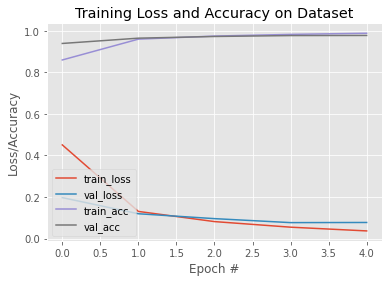

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot")

# serialize the model to disk
torch.save(model_lenet, "LeNet Model")

Task :  Your task is to use the following given code structure and use the model ALEXNET instead of LeNet and train and test it using CFAR10 dataset. Basically your task is to make necessary changes to acheive the given objective.

# AlexNet

In [3]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Dropout
from torch import flatten
import torchvision
import torchvision.models as models

import matplotlib
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [4]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 2048
EPOCHS = 1
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load the dataset
print("[INFO] loading dataset...")

import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

trainData = CIFAR10(root="data", train=True, download=True, transform=transform)
testData = CIFAR10(root="data", train=False, download=True, transform=transform)

print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading dataset...
Files already downloaded and verified
Files already downloaded and verified
[INFO] generating the train/validation split...


In [6]:
model_alexnet = models.alexnet(pretrained=True)
for feature_extraction_layer in model_alexnet.features.parameters():
    feature_extraction_layer.requires_grad = False

last_layer_inputs = model_alexnet.classifier[6].in_features
last_layer = nn.Linear( last_layer_inputs, len(trainData.dataset.classes) )
model_alexnet.classifier[6] = last_layer
model_alexnet.to( device )

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [8]:
# initialize the model
print("[INFO] initializing the model...")
#model_alexnet = AlexNet(numChannels=3, classes=len(trainData.dataset.classes)).to(device)

model_alexnet.eval()

[INFO] initializing the model...


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
opt = Adam(model_alexnet.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
print(type(trainDataLoader),len(trainDataLoader))

<class 'torch.utils.data.dataloader.DataLoader'> 19


In [10]:
# Let's start the training
print("[INFO] training the network...")
startTime = time.time()

# loop over epochs
for e in range(0, EPOCHS):
  model_alexnet.train()                                            # set the model in training mode

  totalTrainLoss = 0 
  totalValLoss = 0
  trainCorrect = 0
  valCorrect = 0
  # loop over the training set
  for (x, y) in trainDataLoader:
    (x, y) = (x.to(device), y.to(device))
  #for i, data in trainDataLoader:                      
    #x, y = data[0].to(device), data[1].to(device) 
    pred = model_alexnet(x)                                         # perform forward pass
    loss = lossFn(pred, y)                                  # calculate the training loss
    
    opt.zero_grad()                                         # zero out the gradients, perform the backpropagation step
    loss.backward()                                         # and update the weights
    opt.step()
    
    totalTrainLoss += loss
    trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

  with torch.no_grad():                             # switch off autograd for evaluation
    model_alexnet.eval()                                    # set the model in evaluation mode
    for (x, y) in valDataLoader:
      (x, y) = (x.to(device), y.to(device))
      pred = model_alexnet(x)                               # # make the predictions
      totalValLoss += lossFn(pred, y)
      valCorrect += (pred.argmax(1) == y).type(
        torch.float).sum().item()
    
  avgTrainLoss = totalTrainLoss / trainSteps
  avgValLoss = totalValLoss / valSteps

  trainCorrect = trainCorrect / len(trainDataLoader.dataset)
  valCorrect = valCorrect / len(valDataLoader.dataset)

  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["train_acc"].append(trainCorrect)
  H["val_loss"].append(avgValLoss.cpu().detach().numpy())
  H["val_acc"].append(valCorrect)

  print("[INFO] EPOCH: {}/{}".format(e+1, EPOCHS))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/1
Train loss: -6783.473145, Train accuracy: 0.1154
Val loss: -38418.410156, Val accuracy: 0.1013

[INFO] total time taken to train the model: 1628.32s


In [14]:
# we can now evaluate the network on the test set
print("[INFO] Testing Trained Model")
with torch.no_grad():
	model_alexnet.eval()
	preds = []
	for (x, y) in testDataLoader:
		x = x.to(device)
		pred = model_alexnet(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

print(classification_report(np.array(testData.targets), np.array(preds), target_names=testData.classes))

[INFO] Testing Trained Model
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.10      1.00      0.18      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


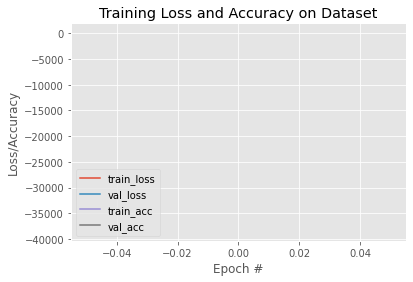

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot")

# serialize the model to disk
torch.save(model_alexnet, "AlexNet Model")